<a href="https://colab.research.google.com/github/jungyoojang/MachineLearning/blob/main/5_2_%EA%B5%90%EC%B0%A8_%EA%B2%80%EC%A6%9D%EA%B3%BC_%EA%B7%B8%EB%A6%AC%EB%93%9C_%EC%84%9C%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차 검증과 그리드 서치

테스트 세트로 평가하면 결국 테스트 세트에 잘 맞는 모델이 만들어지는 것 아닌가 하는 문제

## 검증 세트(validation set)

모델을 만들고 나서 테스트 세트는 딱 한 번 사용되는 것이 좋음

따라서 추가로 훈련 세트를 또 나눔

이 데이터를 검증 세트라고 부름

훈련 세트 60% / 검증 세트 20% / 테스트 세트 20% - 3개로 나눔

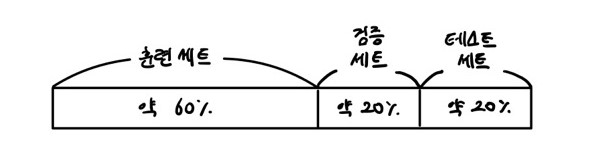

**활용 과정**

1) 모델을 훈련세트로 훈련(fit)하고, 검증세트로 평가(score)한다

2) 매개변수를 바꿔가며 score 점수가 가장 좋은 모델을 고른다

3) 최적의 매개변수로, 훈련세트와 검증세트를 합친 걸 다시 훈련(fit)한다

4) 그리고 맨 마지막에 테스트세트로 최종 점수(score)를 평가한다

In [ ]:
# 검증 세트를 활용한 모델 평가
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
# 입력/타깃 데이터 설정
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
# 훈련/테스트 세트 나누기
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

훈련/검증 세트 분할 단계 추가

In [ ]:
sub_input, val_input, sub_target, val_target = train_test_split(# train_test_split 다시 사용
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
print(sub_input.shape, val_input.shape) # 크기 확인, 훈련세트가 한 번 더 쪼개짐

(4157, 3) (1040, 3)


In [ ]:
from sklearn.tree import DecisionTreeClassifier # 결정 트리 모델

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target) # 훈련

print(dt.score(sub_input, sub_target)) # 훈련세트 평가
print(dt.score(val_input, val_target)) # 검증세트 평가

0.9971133028626413
0.864423076923077


훈련 세트와 검증 세트의 평가 점수를 이용하여 최적화

최적화 완료 후 테스트 세트로 모델을 최종 평가

In [ ]:
print(dt.score(test_input, test_target))

0.8569230769230769


**검증 세트의 문제점?**

검증 세트로 인해 훈련 세트가 줄어듬

보통 많은 데이터를 훈련에 사용할수록 좋은 모델이 만들어짐

검증 세트를 너무 조금 떼어 놓으면 검증 점수가 불안정함

이러한 문제를 보완할 방법이 필요



## 교차 검증(cross vaildation)

훈련세트에서 검증세트를 한번만 떼어내는 게 아니라, 훈련세트를 조각내놓고
그 조각들이 번갈아가면서 검증세트가 되도록 하는 방식.

**폴드**

- 그 조각들을 일컫는 용어

보통 5-폴드 교차 검증이나 10-폴드 교차 검증을 사용

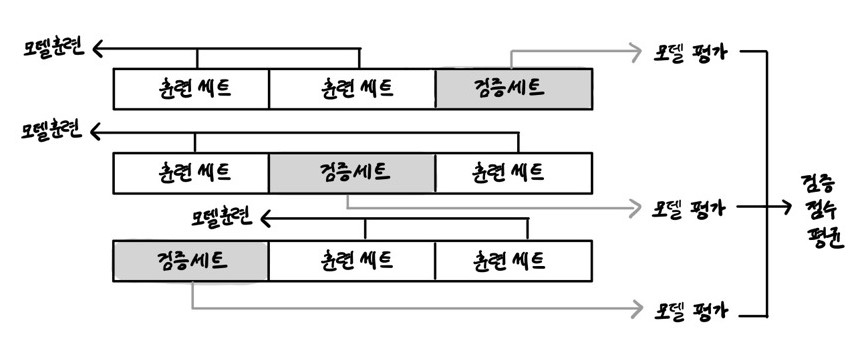

**cross_vaildate()**

- 교차 검증 함수

- 평가할 모델 객체를 첫 번째 매개변수로 전달, 그 다음 직접 검증 세트를 떼어 낼 필요없이, 훈련 세트 전체를 cross_vaildate() 함수에 전달하면 알아서 검증세트 떼어내고 그걸 폴드마다 바꿔가면서 모델을 평가까지 함

In [ ]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.01263452, 0.00943828, 0.00749516, 0.00730348, 0.00698304]), 'score_time': array([0.00168633, 0.00099397, 0.00094175, 0.00095034, 0.00091934]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


교차 검증의 최종 점수

각 폴드별 검증 점수는 'test_score'에 반환되어 있고, 그 점수들을 평균 내면 교차검증의 최종 점수가 되는 거임

주의) 이름은 test_score이지만 테스트 점수가 아닌 검증 점수임

In [ ]:
import numpy as np

print(np.mean(scores['test_score'])) # 교차검증의 최종점수는 평균 내서 계산 가능

0.855300214703487


**주의할 점**

cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않음

만약 train_test_split()를 하지 않았다면 분할기를 지정해야함

cross_validate()는 회귀 모델일 경우 kFold 분할기를 사용하고 분류 모델일 경우 StratfiedKFold를 사용

섞지 않은 것이 디폴트이므로 따로 분할기를 설정해줘야함

- cv: 분할기를 지정하는 매개변수 (기본값=5)

In [ ]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


훈련 세트를 먼저 섞은 후 10-폴드 교차 검증을 수행

In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


cross_validate는 자체적으로 모델을 훈련시키기는 하나 모델 파라미터나 하이터 파라미터를 찾는 것이 아니라 모델의 점수 검증을 위해 사용함

따라서 훈련(fit) 필수

교차 검증 아이디어를 활용하여 하이퍼파라미터 튜닝을 수행

매개변수 값을 바꿔가며 가장 좋은 성능이 나오는 모델을 찾는 과정에서 테스트 세트를 사용하지 않고 교차 검증을 수행



## 하이퍼파라미터 튜닝

모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터



**그리드 서치(grid search)**

하이퍼파라미터 탐색(최적의 매개변수)과 교차 검증을 한 번에 수행

즉, cross_validate()함수를 호출할 필요가 없음

**=GridSearchCV 클래스**



---

예제: 결정 트리 모델에서 min_impurity_decrease 최적값 찾기

GridSearchCV 클래스를 import 하고 탐색할 매개변수와 탐색할 값의 리스트를 딕셔너리로 만듦


In [ ]:
# 그리드 서치
from sklearn.model_selection import GridSearchCV #cross_vaildate() 필요없음
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]} #딕셔너리 생성

GrideSearchCV의 cv 매개변수 기본값은 5이므로 params에서 설정한 5개의 min_impurity_decrese 별로 결정 트리를 5번 실행

즉, 25번의 결정 트리 모델을 훈련 ( 5*5 )

- params : 딕셔너리 형태로 탐색할 매개변수 후보들을 전달하기 위해 사용한 변수

- n_jobs : 작업에 사용할 CPU 코어 수를 지정하는 매개변수 (기본값=1, -1이면 모든 코어 사용 )

In [ ]:
#그리드 서치 객체 생성
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [ ]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

- best_params_ : 찾아낸 최적의 매개변수가 저장된 곳

- best_estimator_ : 최적의 매개변수 조합으로 훈련시킨 최적의 모델이 저장된 곳

In [ ]:
dt = gs.best_estimator_ # 최적의 모델
print(dt.score(train_input, train_target))

0.9615162593804117


In [ ]:
print(gs.best_params_) # 최적의 매개변수

{'min_impurity_decrease': 0.0001}


- cv_results_: 각 매개변수에서 수행한 교차 검증의 평균 점수

In [ ]:
print(gs.cv_results_['mean_test_score']) # 교차 검증의 평균 점수

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


- argmax(): 넘파이에 저장된 함수, 사용하여 가장 큰 값의 인덱스를 추출

params 키에 저장된 매개변수 출력

In [ ]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


**그리드 서치를 이용한 최적화 과정 정리**

1. 탐색할 매개변수 지정
2. 훈련세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합 찾음  (이 조합은 그리드 서치 객체에 저장)
3. 그리드 서치는 최상의 매개변수에서 전체 훈련 세트를 사용해 최종 모델을 훈련 (이 조합은 그리드 서치 객체에 저장)

예제: 결정 트리모델에서 min_impurity_decrease, max_depth, min_samples_split 최적값 찾기

- np.arange() 함수와 range() 함수 활용

In [ ]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001), # 9개의 값
          'max_depth': range(5, 20, 1), # 15개의 값
          'min_samples_split': range(2, 100, 10) # 10개의 값
          } # 9 * 15 * 10 * 5 (5-폴드 교차 검증) = 6,750개의 모델

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1) # 객체 생성, 그리드 서치 수행
gs.fit(train_input, train_target) # 훈련

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

최상의 매개변수 조합 확인

In [ ]:
print(gs.best_params_) # 최상의 매개변수 조합 확인

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


최상의 교차 검증 점수 확인

In [ ]:
print(np.max(gs.cv_results_['mean_test_score'])) # 최상의 교차 검증 점수 확인

0.8683865773302731


찾은 파라미터로 모델을 생성하고 테스트 점수 확인

**아쉬운 점**

1) 매개변수 후보 간격들을 0.001, 1, 10으로 했었는데, 이렇게 간격을 둔 것에 대한 특별한 근거가 없다.

2) 너무 많은 매개변수 조합이 있어서 그리드서치 수행 시간이 오래 걸릴 수 있다.

### 랜덤 서치 (Random Search)

매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있음

이럴때 랜덤 서치를 사용하면 좋음

매개변수 값의 목록이 아닌 매개변수를 샘플링할 수 있는 확률 분포 객체를 전달함

**싸이파이 (scipy)**

파이썬의 핵심 과학 라이브러리 중 하나

stats 서브 패키지 사용

통계학과 관련된 패키지

uniform과 randint 클래스

- uniform: 주어진 범위에서 임의로 실수값을 뽑는 클래스

- randint: 주어진 범위에서 임의로 정숫값을 뽑는 클래스

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
rgen = randint(0, 10)
rgen.rvs(10)

array([2, 8, 8, 4, 9, 5, 8, 0, 4, 2])

10번 샘플링했기 때문에 고르게 샘플링되는 것 같지 않게 보임

그러니 샘플링 숫자를 늘리면 쉽게 확인 가능

In [ ]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 97, 108, 111,  94,  86,  92,  96, 128,  91,  97]))

uniform의 사용법도 동일

In [ ]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.93301391, 0.92596403, 0.83279237, 0.60995599, 0.88820004,
       0.7853352 , 0.92417369, 0.7492526 , 0.85400064, 0.27520182])

**예제: 결정트리 모델에서 min_impurity_decrease, max_depth, min_samples_split, min_samples_leaf 최적값 찾기**

min_samples_leaf: 리프 노드가 되기 위한 최소 샘플의 수

- 어떤 노드가 분할하여 만들어질 자식 노드의 샘플 수가 이 값보다 작으면 분할 안됨

- RandomizedSearchCV(): 랜덤 서치 클래스

- n_iter: 샘플링 횟수 지정하는 매개변수

In [ ]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001), # 난수 발생기
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [ ]:
# 랜덤 서치 객체 생성 및 훈련
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42) # 샘플링 횟수= 100
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f090f346230>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f090f3449d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f090f346650>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f090f3464d0>},
                   random_state=42)

그리드 서치보다 교차 검증 수를 줄이면서 넓은 영역을 효과적으로 탐색 가능

In [ ]:
print(gs.best_params_) # 최적의 매개변수 조합

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score'])) # 최적의 교차 검증 점수

0.8695428296438884


최적의 모델은 이미 전체 훈련 세트로 훈련되어 best_estimator_에 저장됨

In [ ]:
dt = gs.best_estimator_ # 최종 모델 결정

print(dt.score(test_input, test_target)) # 테스트 세트 성능 확인

0.86


**주의**

교차검증, 그리드 서치, 랜덤 서치는 모델을 훈련하는 것이 아니라 검증하는 것임

즉, 적절한 하이퍼파라미터를 찾는데 사용되어야 함

## 확인문제

RandomizedSearchCV 예제에서 DecisionTreeClassifier 클래스에 spliter='random' 매개변수를 추가하고 다시 훈련

spliter='random'이면 무작위로 분할한 다음 가장 좋은 것을 고름

테스트 세트에서 성능이 올라갔는지 내려갔는지 확인

In [ ]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f090f346230>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f090f3449d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f090f346650>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f090f3464d0>},
                   random_state=42)

In [ ]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077


결정 트리의 노드를 랜덤하게 분할하기 때문에 100번의 반복에서 최적의 매개변수 조합을 찾지못함

즉, 평균 검증 점수와 테스트 세트의 점수가 모두 조금 낮음

## 정리

테스트 세트에만 맞춰진 거 아니냐는 문제점

-> 검증 세트 추가

-> 검증세트까지 떼어내는 문제점 발생

-> 교차검증으로 해결

-> 매개변수를 바꿔가면서 평가하는 과정이 복잡하다는 문제점 발생

-> 그 과정을 자동화한 그리드서치 활용

-> 간격 설정에 관한 한계가 있고, 시간이 오래 걸린다는 문제점 발생

-> 넓은 범위 속을 무작위로 탐색하여 효율적인 랜덤서치로 해결